Using data from Central electoral commission of Lithuanina analyze 2d round results of 2023 municipality elections.

1. found candidates, who got statistically higher voters support by mail than their opponents in the same municipality

In [44]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

df = pd.read_csv("../data/VN_1304_2_1920.csv", delimiter="\t")

df.info()
#we need column BALSU_PASTU and BALSU_VISO for analysis, they both don't have null values and int type
#so it's good for analysis, and each district has only 2 candidates as it's 2nd round of election

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   APYGARDOS_NR                 2362 non-null   int64  
 1   APYGARDOS_PAVADINIMAS        2362 non-null   object 
 2   APYLINKES_NR                 2362 non-null   int64  
 3   APYLINKES_PAVADINIMAS        2362 non-null   object 
 4   RINKEJU_SKAICIUS             2362 non-null   int64  
 5   VISO_DALYVAVO                2362 non-null   int64  
 6   BALSADEZEJE_GALIOJANTYS      2362 non-null   int64  
 7   BALSADEZEJE_NEGALIOJANTYS    2362 non-null   int64  
 8   PASTU_GALIOJANTYS            2362 non-null   int64  
 9   PASTU_NEGALIOJANTYS          2362 non-null   int64  
 10  VARDAS                       2362 non-null   object 
 11  PAVARDE                      2362 non-null   object 
 12  PARTIJA                      2333 non-null   object 
 13  BALSU_BALSADEZEJE 

In [45]:
df.head()

,APYGARDOS_NR,APYGARDOS_PAVADINIMAS,APYLINKES_NR,APYLINKES_PAVADINIMAS,RINKEJU_SKAICIUS,VISO_DALYVAVO,BALSADEZEJE_GALIOJANTYS,BALSADEZEJE_NEGALIOJANTYS,PASTU_GALIOJANTYS,PASTU_NEGALIOJANTYS,...,PAVARDE,PARTIJA,BALSU_BALSADEZEJE,BALSU_PASTU,BALSU_VISO,PAPILDOMO_PROTOKOLO_POZYMIS,RKND_V_AR_ISSIKELE_PATS,RPL_UNIKALUS_NUMERIS,SAV,Sugeneravimo data
0,3,Alytaus rajono,2,Mikutiškių,770,417,328,2,85,2,...,VITKAUSKIENĖ,Demokratų sąjunga „Vardan Lietuvos“,185,29,214,NaN,NaN,3002,Alytaus rajono savivaldybė,2023-03-24 16:17
1,3,Alytaus rajono,2,Mikutiškių,770,417,328,2,85,2,...,VRUBLIAUSKAS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,143,56,199,NaN,NaN,3002,Alytaus rajono savivaldybė,2023-03-24 16:17
2,3,Alytaus rajono,3,Genių,393,215,177,1,36,1,...,VRUBLIAUSKAS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,95,16,111,NaN,NaN,3003,Alytaus rajono savivaldybė,2023-03-24 16:17
3,3,Alytaus rajono,3,Genių,393,215,177,1,36,1,...,VITKAUSKIENĖ,Demokratų sąjunga „Vardan Lietuvos“,82,20,102,NaN,NaN,3003,Alytaus rajono savivaldybė,2023-03-24 16:17
4,3,Alytaus rajono,4,Miklusėnų,1319,774,671,8,95,0,...,VITKAUSKIENĖ,Demokratų sąjunga „Vardan Lietuvos“,363,45,408,NaN,NaN,3004,Alytaus rajono savivaldybė,2023-03-24 16:17


In [46]:
#we create a list for significant_candidates in municipality(apygarda) for votes per mail
significant_candidates = []

# Group by municipality
for district, group in df.groupby("APYGARDOS_PAVADINIMAS"):
    # in each municipality groups by surname and party and sums the votes
    candidates = group.groupby(["PAVARDE", "PARTIJA"]).agg({
        "BALSU_PASTU": "sum",   # Sum of mail votes per candidate
        "BALSU_VISO": "sum"     # Sum of votes per candidate
    }).reset_index()

    # check if there are exactly 2 candidates   
    if len(candidates) != 2:
        continue

    # Get the two candidates
    c1, c2 = candidates.iloc[0], candidates.iloc[1]

    # Test both directions: is c1 > c2 or c2 > c1?
    # Perform a proportion z-test Is candidate's mail to total votes percent significantly higher than opponent's?
    for candidate, opponent in [(c1, c2), (c2, c1)]:
        stat, pval = proportions_ztest(
            [candidate["BALSU_PASTU"], opponent["BALSU_PASTU"]],
            [candidate["BALSU_VISO"], opponent["BALSU_VISO"]],
            alternative='larger'
        )
        # There is less than a 5% chance that the observed difference in mail-in vote proportions happened by random chance 
        # — we treat the difference as statistically significant
        if pval < 0.05:
            # Save candidate info to the results list
            significant_candidates.append({
                "PAVARDE": candidate["PAVARDE"],
                "PARTIJA": candidate["PARTIJA"],
                "APYGARDOS_PAVADINIMAS": district,
                "MAIL_PROPORTION": candidate["BALSU_PASTU"] / candidate["BALSU_VISO"],
                "P_VALUE": pval
            })
            break  # only save one winner per district

# Convert to DataFrame
result_df = pd.DataFrame(significant_candidates)
# Save to CSV
result_df.to_csv("../data/significant_candidates.csv", index=False)
result_df.head()


,PAVARDE,PARTIJA,APYGARDOS_PAVADINIMAS,MAIL_PROPORTION,P_VALUE
0,VRUBLIAUSKAS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,Alytaus rajono,0.300968,1.847743e-49
1,ŽIOGELIS,Lietuvos socialdemokratų partija,Anykščių rajono,0.315731,1.387370e-06
2,KNIZIKEVIČIUS,Lietuvos socialdemokratų partija,Biržų rajono,0.339975,1.269485e-12
3,TOMKUS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,Kaišiadorių rajono,0.300000,1.675380e-04
4,BABECKAS,Demokratų sąjunga „Vardan Lietuvos“,Kalvarijos,0.334096,1.552150e-03


2. žemėlapyje pavaizduokite rinkimų apylinkes ir partijas, kurių kandidatų tose apylinkėse gauto
palaikymo dalis, skirta balsais paštu, buvo statistiškai reikšmingai didesnė, lyginant su jų
konkurentais toje pačioje rinkimų apylinkėje tame pačiame rinkimų ture.

In [47]:
# Make significant candidates in smaller districts(apylinke) DataFrame for votes per mail

significant = []
#group by district
for name, group in df.groupby("APYLINKES_PAVADINIMAS"):
    candidates = group.groupby(["PAVARDE", "PARTIJA"]).agg({
        "BALSU_PASTU": "sum",
        "BALSU_VISO": "sum"
    }).reset_index()
# check if there are exactly 2 candidates
    if len(candidates) != 2:
        continue
# Get the two candidates
    c1, c2 = candidates.iloc[0], candidates.iloc[1]

    # Test both directions: is c1 > c2 or c2 > c1?
    for candidate, opponent in [(c1, c2), (c2, c1)]:
        stat, pval = proportions_ztest(
            [candidate["BALSU_PASTU"], opponent["BALSU_PASTU"]],
            [candidate["BALSU_VISO"], opponent["BALSU_VISO"]],
            alternative='larger'
        )
    # There is less than a 5% chance that the observed difference in mail-in vote proportions happened by random chance 
        # — we treat the difference as statistically significant    
        if pval < 0.05:
            significant.append({
                "APYLINKES_PAVADINIMAS": name,
                "PARTIJA": candidate["PARTIJA"]
            })
            break # only save one winner per district

# Create DataFrame 
df_sig = pd.DataFrame(significant)

# Make sure apylinkės names match format
df_sig["APYLINKES_PAVADINIMAS"] = df_sig["APYLINKES_PAVADINIMAS"].str.strip().str.upper()


In [48]:
#Visualize the results on a map
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
#load coordinates from excel
coords_df = pd.read_excel("../data/Rinkimu_apylinkes_2024-08-29.xlsx")

# Rename coordinates columns
coords_df = coords_df.rename(columns={
    "Balsavimo X koordinatė": "X",
    "Balsavimo Y koordinatė": "Y"
})
coords_df["APYLINKES_PAVADINIMAS"] = coords_df["Apylinkės pavadinimas"].str.strip().str.upper()

# Convert to GeoDataFrame (LKS94 EPSG:3346 → to match Excel)
gdf = gpd.GeoDataFrame(
    coords_df,
    geometry=gpd.points_from_xy(coords_df["X"], coords_df["Y"]),
    crs="EPSG:3346"
)
# Reproject to WGS84 for merging with df_sig DataFrame
gdf_latlon = gdf.to_crs(epsg=4326)

gdf_latlon = gdf_latlon.merge(df_sig[["APYLINKES_PAVADINIMAS", "PARTIJA"]], on="APYLINKES_PAVADINIMAS", how="left")

# Reproject to Web Mercator (EPSG:3857) for basemap
gdf_3857 = gdf_latlon.to_crs(epsg=3857)

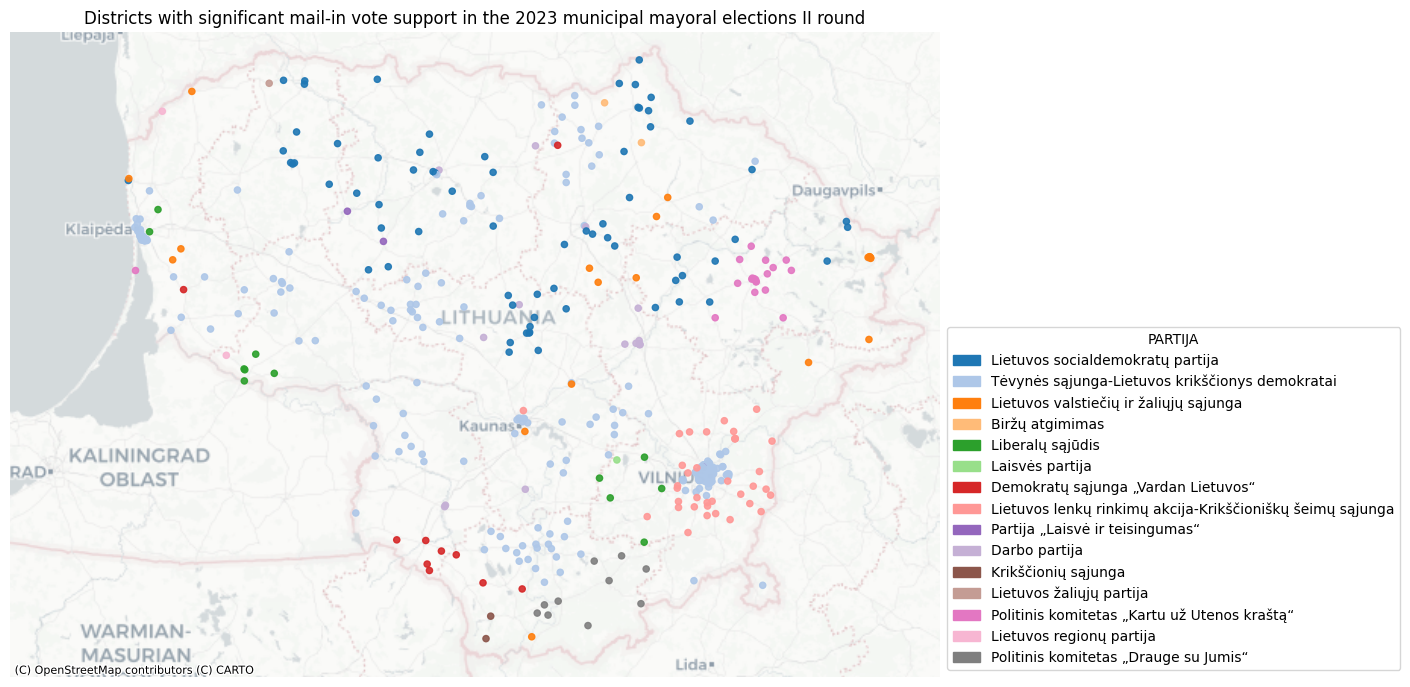

In [49]:
# Plotting
# Step 1: apylinkes where there is no significant support will be dropped
parties = gdf_3857["PARTIJA"].dropna().unique()

# Step 2: Create a distinct color for each party
cmap = ListedColormap(plt.cm.tab20.colors[:len(parties)]) # lets us use these specific colors to map to parties.

# Step 3: party_colors creates a dictionary like:
# { "Liberalai": 0, "Socdemai": 1, "TS-LKD": 2, ... }
# Then we map this dictionary to a new column "color_index", so each municipality has a color index assigned.
party_colors = {party: i for i, party in enumerate(parties)}
gdf_3857["color_index"] = gdf_3857["PARTIJA"].map(party_colors)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Color is determined by the "color_index" column and cmap
gdf_3857.plot(
    ax=ax,
    column="color_index",
    cmap=cmap,
    markersize=20,
    alpha=0.9,
    legend=False  # We'll create a custom legend below
)
# Custom legend
legend_handles = [
    mpatches.Patch(color=cmap(i), label=party)
    for i, party in enumerate(parties)
]
ax.legend(handles=legend_handles, title="PARTIJA", loc="lower left", bbox_to_anchor=(1, 0))
# Add basemap of Lithuania
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set map extent to Lithuania
ax.set_xlim(2250000, 3000000)
ax.set_ylim(7140000, 7660000)

# Finalize plot
ax.set_axis_off()
plt.title("Districts with significant mail-in vote support in the 2023 municipal mayoral elections II round")
plt.savefig('../output/chart1.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()